In [1]:
"""
Based off of:

https://github.com/jamesmcinerney/vi_ibp/
"""

'\nBased off of:\n\nhttps://github.com/jamesmcinerney/vi_ibp/\n'

In [2]:
import numpy as np
import random
from scipy.special import psi
import sys
import os
import time

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(123)

In [3]:
def generate_synthetic_data(N, K, d1, d2):
    """
    Generates synthetic dataset of images with a fixed basis
    
    X = Zs
    X \in NxD
    Z \in NxK
    s \in KxD
    
    D = d1xd2
    
    Args:
        N: number of points in the data set
        K: number of underlying features
        d1: length of first dimension
        d2: length of second dimension
        
    Returns:
        s: array K x D dictionary of features
        X: synthetically generated dataset
        
    """
    D = d1*d2
    
    #define some shapes
    s = np.zeros((K,D))

    assert K == 8, "we have 8 dims for K"

    s[0,:] = np.array([[0,0,1,0],
                       [1,1,1,1],
                       [0,0,1,0],
                       [0,0,0,0]]).flatten()
    s[1,:] = np.array([[0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0],
                       [0,1,0,0]]).flatten()
    s[2,:] = np.array([[1,1,1,1],
                       [0,0,0,0],
                       [0,0,0,0],
                       [0,0,0,0]]).flatten()
    s[3,:] = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0],
                       [0,0,0,1]]).flatten()
    s[4,:] = np.array([[0,0,0,0],
                       [0,0,0,0],
                       [1,1,0,0],
                       [1,1,0,0]]).flatten()
    s[5,:] = np.array([[1,1,1,1],
                       [1,0,0,1],
                       [1,0,0,1],
                       [1,1,1,1]]).flatten()
    s[6,:] = np.array([[0,0,0,0],
                       [0,1,1,0],
                       [0,1,1,0],
                       [0,0,0,0]]).flatten()
    s[7,:] = np.array([[0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1],
                       [0,0,0,1]]).flatten()

    pr_z = 0.3
    w = np.random.uniform(0.5, 1.0, K) # weight of features
    mut = w[:,np.newaxis]*s
    z = np.random.binomial(1, pr_z, (N, K)) # each feature occurs with prob 0.3 independently 
    X = np.dot(z,mut) + np.random.randn(N, D)*0.1 

    return s, X

In [34]:
def plot_grid(X, d1, d2, final=0, title='', order='C'):
    #takes a NxD matrix and plots N d1xd2 images (where d1xd2==D)
    (N,D) = np.shape(X)
    n1 = int(np.sqrt(N))+1
    fig, ax = plt.subplots(n1, n1)
    n = 0
    for i in range(n1):
        for j in range(n1):
            if n >= N: break
            imgplot = ax[i,j].imshow(np.reshape(X[n,:], (d1,d2), order=order).T,
                                     cmap=cm.Greys_r) #, vmin=0, vmax=2)
            imgplot.set_interpolation('nearest')
            n += 1 
    fig.suptitle(title)
    fig.show()

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


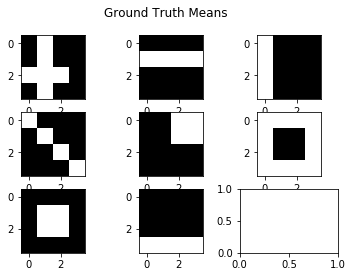

In [35]:
################################
## Generate synthetic dataset ##
################################
N = 500
d1, d2 = 4, 4
D = d1*d2
K = 8
dictionary, X = generate_synthetic_data(N, K, d1, d2)
plot_grid(dictionary, d1, d2, title='Ground Truth Means')

In [23]:
X.shape

(500, 16)

In [70]:
#######################
## Model Hyperparams ##
#######################
K = 15
sigma_A = 0.1
sigma_n = 0.1
alpha = 1

#############################
## Optimization parameters ##
#############################
rounds = 200

############################
## Variational parameters ##
############################
Phi = 0.1 * np.ones((D, D, K))
phi = np.random.uniform(0, 1, (K, D))
tau = np.random.uniform(0, 1, (K, 2))
nu = np.random.uniform(0, 1, (N, K))
nu = nu/np.sum(nu, axis=1).reshape((-1,1)) # want contributions from features space to sum to 1

In [76]:
for t in range(rounds):
    if t % 100 == 0:
        print("Iter: {}".format(t))
        
    # Local updates for variational Bernoulli parameters
    A = np.zeros((N, K))
    P = X - np.dot(nu, phi) # N x D
    v = np.zeros((N, K))
    for k in range(K):
        # eqn on p 28 of Doshi
        # for all n and k!
        A[:, k] = np.dot(phi[k, :], # D
                         np.transpose(P + np.outer(nu[:, k], phi[k, :]))
                         ) # D x (N x D) = N
        
        v[:, k] = psi(tau[k, 0]) + psi(tau[k, 1]) -\
                    (0.5/(sigma_n**2))*(np.trace(Phi[:,:,k]) +\
                    np.dot(phi[k, :], phi[k, :])) + (1/(sigma_n**2))*A[:,k]
                                        
        nu[:, k] = 1.0 / (1.0 + np.exp(-v[:, k]))    
    # Update the variational parameters for the Gaussian dictionary    
    # eqn on page 27 of Doshi 
    # for all k
    for k in range(K):
        Phi[:, :, k]    = (1.0/(1/sigma_A**2 + (1/sigma_n**2) * np.sum(nu[:,k]))) * np.identity(D)
        phi[k, :]       = (1/sigma_n**2) * \
                           np.dot(nu[:, k].T, X - np.dot(nu, phi) + np.outer(nu[:, k], phi[k, :])) *\
                           Phi[0, 0, k]

    # Update variational Beta parameters
    # eqn on page 28 of Doshi
    nu_sum = np.sum(nu_local, axis=0)
    tau_tmp[:, 0] = alpha/K + nu_sum
    tau_tmp[:, 1] = N + 1 - nu_sum

Iter: 0
Iter: 100


/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


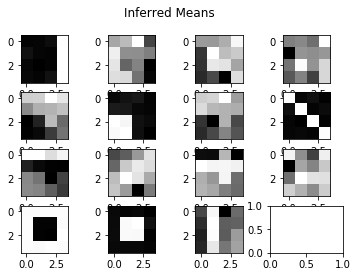

In [77]:
plot_grid(phi, d1, d2, title='Inferred Means', order='F')